In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import os

from tqdm.notebook import tqdm

# Get Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Auxiliar Functions

In [120]:
def show_image(image,label,get_denormalize = True):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image, title = None):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.ylabel(title)
    plt.imshow(image)

def show_images(images, labels, row=4, cols=4):
    # imgs = imgs.detach().numpy().transpose(0, 2, 3, 1)
    # now we need to unnormalize our images. 
    # fig = plt.figure(figsize = (9,9))
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(row, cols, figsize = (9, 9))
    axes = axes.flatten()
    for image, label, ax in zip(images, labels, axes):
      image = image.permute(1, 2, 0)  
      image = image*std + mean
      image = np.clip(image,0,1)

      ax.imshow(image)
      ax.set_xlabel(CFG.class_name[label])
    plt.tight_layout()
    plt.show()

def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    classes = np.array(CFG.class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(CFG.class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
class CFG:
  epochs = 20                             # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path='/content/dataset/Brain_Data_Organised/Train'
  test_path='/content/dataset/Brain_Data_Organised/Test'

  class_name =["NORMAL", "STROKE"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

# Create Datasets

In [ ]:
from torchvision import transforms as T, datasets

train_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

validate_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

test_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

In [ ]:
full_dataset = datasets.ImageFolder(CFG.train_path, transform = train_transform)
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])
test_set = datasets.ImageFolder(CFG.test_path, transform = test_transform)

In [ ]:
print("Trainset Size:  {}".format(len(train_set)))
print("Trainset Size:  {}".format(len(valid_set)))
print("Trainset Size:  {}".format(len(test_set)))

Trainset Size:  1800
Trainset Size:  451
Trainset Size:  250


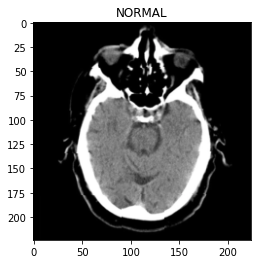

In [ ]:
img, label = train_set[20]
#print(train_set.class_to_idx)

show_image(img, CFG.class_name[label])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

train_loader = DataLoader(train_set, batch_size = CFG.batch_size, shuffle = True)
print("No. of batches in trainloader: {}".format(len(train_loader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples: {}".format(len(train_loader.dataset)))

No. of batches in trainloader: 113
No. of Total examples: 1800


In [ ]:
valid_loader = DataLoader(valid_set, batch_size = CFG.batch_size, shuffle = True)
print("No. of batches in validation loader: {}".format(len(valid_loader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples: {}".format(len(valid_loader.dataset)))

No. of batches in validation loader: 29
No. of Total examples: 451


In [129]:
test_loader = DataLoader(test_set, batch_size = CFG.batch_size, shuffle = False)
print("No. of batches in testloader: {}".format(len(test_loader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples: {}".format(len(test_loader.dataset)))

No. of batches in testloader: 16
No. of Total examples: 250


# Show Image Samples

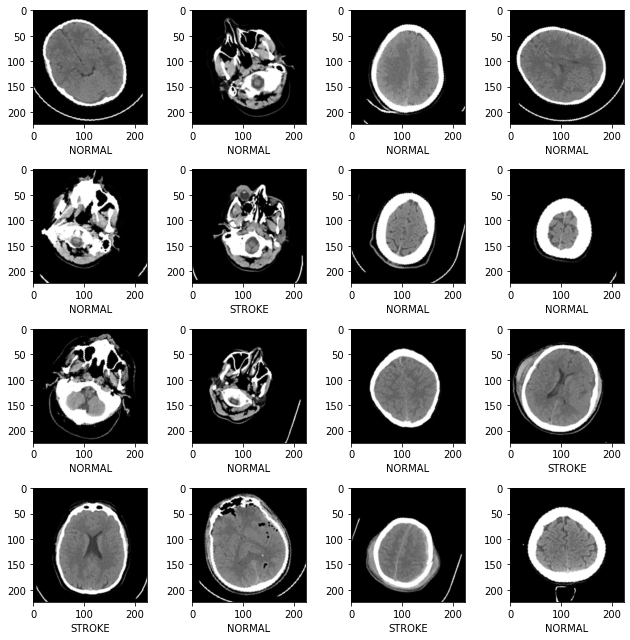

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

show_images(images, labels, row=4, cols=4)

# EfficientNet

## Build Model

In [ ]:
!pip install timm # install PyTorch Image Models

     |████████████████████████████████| 376 kB 5.1 MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name, pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [ ]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

In [ ]:
from torchsummary import summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

## Train Model

In [ ]:
class CustomTrainer():
    
    def __init__(self, criterion = None, optimizer = None, schedular = None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'CustomModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = CustomTrainer(criterion, optimizer)
trainer.fit(model, train_loader, valid_loader, epochs = CFG.epochs)

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6485640273011964
Epoch : 1 Train Loss : 0.635005 Train Acc : 0.659845
Epoch : 1 Valid Loss : 0.648564 Valid Acc : 0.607759


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.605314 Train Acc : 0.670354
Epoch : 2 Valid Loss : 0.649773 Valid Acc : 0.596264


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.6485640273011964 --> 0.6320229984562973
Epoch : 3 Train Loss : 0.564476 Train Acc : 0.711283
Epoch : 3 Valid Loss : 0.632023 Valid Acc : 0.676724


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.6320229984562973 --> 0.5798758915786085
Epoch : 4 Train Loss : 0.562484 Train Acc : 0.721239
Epoch : 4 Valid Loss : 0.579876 Valid Acc : 0.702586


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.530490 Train Acc : 0.741704
Epoch : 5 Valid Loss : 0.629635 Valid Acc : 0.668103


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.5798758915786085 --> 0.5614844694219786
Epoch : 6 Train Loss : 0.527694 Train Acc : 0.738938
Epoch : 6 Valid Loss : 0.561484 Valid Acc : 0.714799


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.488988 Train Acc : 0.761062
Epoch : 7 Valid Loss : 0.624393 Valid Acc : 0.690374


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.479573 Train Acc : 0.758296
Epoch : 8 Valid Loss : 0.587115 Valid Acc : 0.702586


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.5614844694219786 --> 0.5291909626845656
Epoch : 9 Train Loss : 0.489617 Train Acc : 0.767699
Epoch : 9 Valid Loss : 0.529191 Valid Acc : 0.738506


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.455807 Train Acc : 0.773230
Epoch : 10 Valid Loss : 0.529695 Valid Acc : 0.720546


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.5291909626845656 --> 0.5006193256583708
Epoch : 11 Train Loss : 0.455210 Train Acc : 0.780973
Epoch : 11 Valid Loss : 0.500619 Valid Acc : 0.758621


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.447126 Train Acc : 0.793142
Epoch : 12 Valid Loss : 0.515966 Valid Acc : 0.743535


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.437496 Train Acc : 0.794801
Epoch : 13 Valid Loss : 0.565164 Valid Acc : 0.719109


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.440124 Train Acc : 0.795907
Epoch : 14 Valid Loss : 0.511897 Valid Acc : 0.753592


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.5006193256583708 --> 0.47918354334502383
Epoch : 15 Train Loss : 0.404810 Train Acc : 0.812500
Epoch : 15 Valid Loss : 0.479184 Valid Acc : 0.767241


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.47918354334502383 --> 0.4522548759805745
Epoch : 16 Train Loss : 0.420053 Train Acc : 0.806969
Epoch : 16 Valid Loss : 0.452255 Valid Acc : 0.786638


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.387310 Train Acc : 0.824668
Epoch : 17 Valid Loss : 0.529578 Valid Acc : 0.751437


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.389412 Train Acc : 0.823562
Epoch : 18 Valid Loss : 0.452566 Valid Acc : 0.785201


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.363550 Train Acc : 0.837389
Epoch : 19 Valid Loss : 0.505904 Valid Acc : 0.771552


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.391080 Train Acc : 0.825221
Epoch : 20 Valid Loss : 0.453140 Valid Acc : 0.790948


In [123]:
!cp '/content/CustomModel.pt' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/CustomModel.pt'

## Evaluate Model

In [130]:
model.load_state_dict(torch.load('/content/CustomModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model, test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/16 [00:00<?, ?it/s]

Test Loss : 0.6665653437376022
Test Acc : 0.624218761920929


## Make Predictions

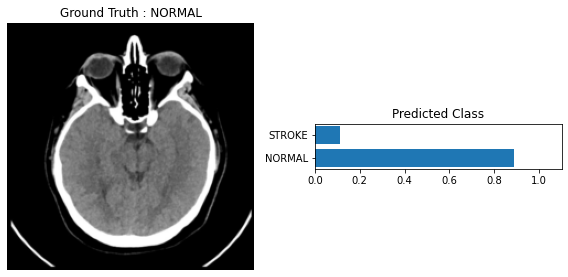

In [131]:
import torch.nn.functional as F

image, label = test_set[17]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)

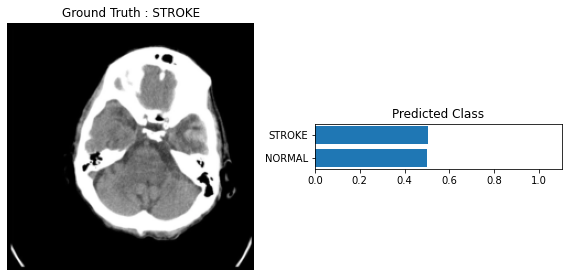

In [134]:
import torch.nn.functional as F

image, label = test_set[167]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)

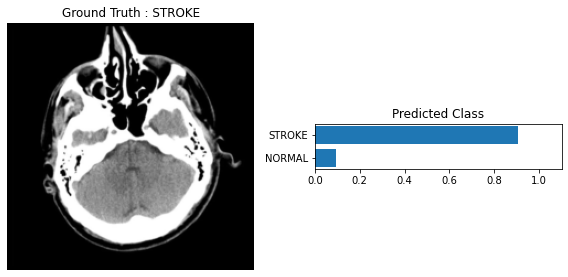

In [133]:
import torch.nn.functional as F

image, label = test_set[187]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)